### University of Virginia
### DS 5110: Big Data Systems
### K-Means Cluster Analysis of Fidelity Fund Returns 
### Last updated: March 11, 2023

## Instructions

In this assignment, you will conduct a k-means cluster analysis on a set of Fidelity mutual funds.  
This helps to group similar funds based on their performance (as opposed to their description, which is typical).  
The outline below will walk you through the required steps.  

This assignment is worth a total of **10 POINTS.**

## Data Details 

The file *fido_returns_funds_on_rows.csv* is the processed data for k-means. Additional details about this file: 
- Each row represents a mutual fund  
- Each column represents a trading day (these are used as features)  
- Each value represents the daily percentage change in price between the current trading day and previous trading day

### Load Modules and Read Data into Spark DataFrame

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

In [4]:
# Loads data
df = spark.read.csv("fido_returns_funds_on_rows.csv", header=True, inferSchema=True)
#df.show(5)

**(VALUE: 2 POINTS) Assemble the Features into a column. 
Show the first five rows of data ONLY for the features column.
(this should make things easier to read)**

In [6]:
feats =  df.columns     
assembler = VectorAssembler(inputCols=feats, outputCol="features")
dataset=assembler.transform(df)
dataset.select('features').show(5)
#dataset.select("*").show(truncate=False)

+--------------------+
|            features|
+--------------------+
|[0.0,0.0,-0.01040...|
|[0.0,0.0,-0.01051...|
|[0.0,0.0,-0.01076...|
|[0.0,8.26105E-4,-...|
|[0.0,8.2815740000...|
+--------------------+
only showing top 5 rows



**(VALUE: 1 POINT) Set up the k-means model and train the model**  
Use parameters: 
- 3 clusters
- maximum of 10 iterations 
- seed=314

In [7]:
kmeans = KMeans().setK(3).setSeed(314).setMaxIter(10)
model = kmeans.fit(dataset)

23/09/27 14:26:15 WARN DAGScheduler: Broadcasting large task binary with size 1028.9 KiB


In [8]:
predictions = model.transform(dataset)

**(VALUE: 2 POINTS) Compute and Print the Silhouette Score**  

In [9]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.49487498540248875


**(VALUE: 2 POINTS) Define a function `kmeans_range()` that does the following:**
- takes an integer representing the lower bound for k
- takes an integer representing the upper bound for k
- take a Spark DataFrame containing training data
- fit K-means with k ranging from lower bound to upper bound, inclusive  
- the other parameters should be the same as earlier 
- for each k, compute the silhouette score
- return a pandas dataframe with columns containing k, silhouette score (each row holds the score for given k)

In [10]:
import pandas as pd

def kmeans_range(df, low, high):
    silhouettes = []
    for i in range(low, high+1):
        kmeans = KMeans().setK(i).setSeed(314).setMaxIter(10)
        model = kmeans.fit(df)
        predictions = model.transform(df)
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        silhouettes.append(silhouette)
    pandas_df = pd.DataFrame(list(zip(range(low, high+1), silhouettes)),
               columns =['K-Clusters', 'Silhouette'])
    return pandas_df

**(VALUE: 1 POINT) Call `kmeans_range` to compute K-means with clusters ranging from 2 to 10 inclusive, printing the resulting dataframe.**

In [14]:
clusters_df = kmeans_range(dataset, 2, 10)
clusters_df

23/09/27 14:43:26 WARN DAGScheduler: Broadcasting large task binary with size 1015.4 KiB


23/09/27 14:43:32 WARN DAGScheduler: Broadcasting large task binary with size 1028.9 KiB


23/09/27 14:43:38 WARN DAGScheduler: Broadcasting large task binary with size 1042.4 KiB


23/09/27 14:43:44 WARN DAGScheduler: Broadcasting large task binary with size 1056.0 KiB


23/09/27 14:43:50 WARN DAGScheduler: Broadcasting large task binary with size 1069.5 KiB


23/09/27 14:43:57 WARN DAGScheduler: Broadcasting large task binary with size 1083.1 KiB


23/09/27 14:44:03 WARN DAGScheduler: Broadcasting large task binary with size 1096.6 KiB


23/09/27 14:44:08 WARN DAGScheduler: Broadcasting large task binary with size 1110.1 KiB


23/09/27 14:44:15 WARN DAGScheduler: Broadcasting large task binary with size 1123.7 KiB


,K-Clusters,Silhouette
0,2,0.602396
1,3,0.494875
2,4,0.500796
3,5,0.459426
4,6,0.419757
5,7,0.462851
6,8,0.304614
7,9,0.371187
8,10,0.403217


**(VALUE: 1 POINT) Produce a plot with cluster numbers k on the x-axis, sihouette scores on the y-axis**

In [15]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

Text(0, 0.5, 'Silhouette Scores')

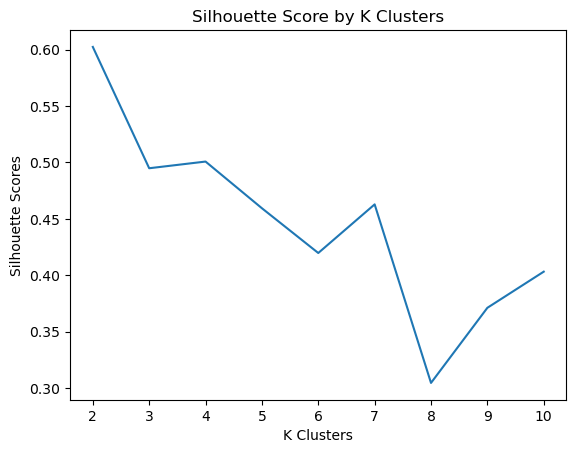

In [19]:
plt.plot(clusters_df['K-Clusters'],clusters_df['Silhouette'])
plt.title('Silhouette Score by K Clusters')
plt.xlabel('K Clusters')
plt.ylabel('Silhouette Scores')

**(VALUE: 1 POINT) Based on how the silhouette score is calculated, what is its time complexity? (e.g., O(log n))**  
You can find the definition of the silhouette score in the lecture notes, for example. 

$O(n^2)$ since we need to compute the distance from one point to each other point, and we would do that $n$ times for each point.